**Task 1, Question 1:** **Performance of Logistics Regression**

a) Build a regression model with no regularization, report accuracy, precision, recall, AUC

b) Use Lasso Regularization
  1) experiment with different levels of regularization, adjust strength parameter from weak to strong
  2) report best model performance
  3) What's the best value of strength parameter (alpha)? What are the variables kept?

c) Based on b), characterize high and low-probability churning customers with the logistic regression results. Is the output same as intuitions?


In [ ]:
#part a) of question 1
#Feature Engineering
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

path = '/content/churn.csv' # <- pls change this thing 'xxx.csv'if the entire ipynb doesn't work!!
data = pd.read_csv(path)
data = pd.get_dummies(data, columns=['gender','Partner','Dependents','PhoneService','MultipleLines',
                                     'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                                     'StreamingMovies','Contract','PaperlessBilling', 'PaymentMethod'])

In [ ]:
#split data and data organization
from sklearn.model_selection import train_test_split
features = data.columns[data.columns != 'Churn']
target = ['Churn']
X = data[features]
Y = (data['Churn'].astype(str).str.strip().str.lower() == 'yes').astype(int)
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.3,random_state=100)

In [ ]:
#Preprocessing data and Z-score stdscaler
from sklearn import preprocessing
processed_xtrain = preprocessing.StandardScaler().fit(xtrain)
processed_xtrain_df = pd.DataFrame(processed_xtrain.transform(xtrain),columns=xtrain.columns)
processed_xtest = preprocessing.StandardScaler().fit(xtest)
processed_xtest_df = pd.DataFrame(processed_xtest.transform(xtest),columns=xtest.columns)

In [ ]:
#Model Training
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(processed_xtrain_df,ytrain)

LogisticRegression()

In [ ]:
#Run Cross Validation, k = 10 -> find the CV probability prediction and true predictions
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

log_model_prob_predict_cv = cross_val_predict(log_model, processed_xtrain_df,ytrain.values.ravel(),cv=10, method = 'predict_proba')
log_model_predict_cv = cross_val_predict(log_model, processed_xtrain_df,ytrain.values.ravel(),cv=10)
log_model_prob_predict_1_cv = log_model_prob_predict_cv[:,1]
log_model_prob_predict_1_cv

array([0.21061826, 0.29999736, 0.66012269, ..., 0.04354706, 0.10152949,
       0.05574476])

In [ ]:
#CV-scores of logistic regression model
log_cv_accuracy = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='accuracy',cv=10).mean()
log_cv_precision = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='precision',cv=10).mean()
log_cv_recall = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='recall',cv=10).mean()
log_cv_auc = cross_val_score(log_model,processed_xtrain_df,ytrain,scoring='roc_auc',cv=10).mean()

In [ ]:
#ROC Curve and AUC Calculation
from sklearn.metrics import roc_curve
log_fpr, log_tpr, log_thresholds = roc_curve(ytrain,log_model_prob_predict_1_cv)
print(len(pd.Series(log_thresholds).value_counts()))

1312


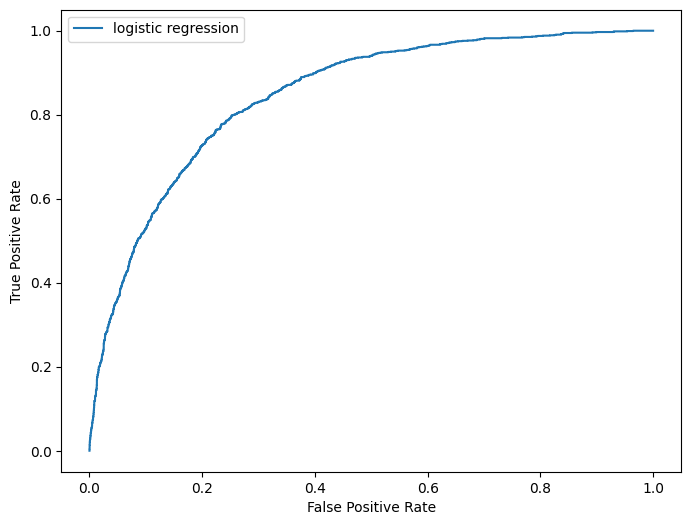

In [ ]:
# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(log_fpr,log_tpr, label="logistic regression")
plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [ ]:
print(f'Accuracy: {log_cv_accuracy}, Precision: {log_cv_precision}, Recall: {log_cv_recall}, AUC: {log_cv_auc}')

Accuracy: 0.8033348999818599, Precision: 0.6515523765997102, Recall: 0.5353379360465117, AUC: 0.8469541069670727


In [ ]:
#Set logistic regression with LASSO regularization
log_model_l1 = LogisticRegression(penalty='l1',max_iter=1000, solver = 'liblinear')
log_model_l2 = LogisticRegression(penalty='l2',max_iter=1000)

In [ ]:
#L1-Regularization Best Model and Model Performance
l1_grid = {"C":[10**i for i in np.arange(-1,0,0.1)]}
l1_searcher = GridSearchCV(log_model_l1,l1_grid,cv=10)
l1_searcher.fit(processed_xtrain_df,ytrain.values.ravel())

print(f"Best C for logsitic regression L1: {l1_searcher.best_params_}")
print(f"Best AUC: {l1_searcher.best_score_}")

#Best C for logsitic regression L1: {'C': np.float64(0.19952623149688792)}
#Best AUC: 0.8045544121769819

Best C for logsitic regression L1: {'C': np.float64(0.19952623149688792)}
Best AUC: 0.8045544121769819


In [ ]:
#L2-Regularization Best Model and Model Performance
l2_grid = {"C":[10**i for i in np.arange(-1,0,0.1)]}
l2_searcher = GridSearchCV(log_model_l2,l2_grid,cv=10)
l2_searcher.fit(processed_xtrain_df,ytrain.values.ravel())

print(f"Best C for logsitic regression L2: {l2_searcher.best_params_}")
print(f"Best AUC: {l2_searcher.best_score_}")

#Best C for logsitic regression L2: {'C': np.float64(0.12589254117941673)}
#Best AUC: 0.8039446560794208

Best C for logsitic regression L2: {'C': np.float64(0.12589254117941673)}
Best AUC: 0.8039446560794208


In [ ]:
#Train the optimal logistic models with optimal L1 and L2 LASSO Regressions
#Optimal C found above
OptimalLASSO1 = LogisticRegression(penalty='l1',C=0.19952623149688792, solver = 'liblinear')
OptimalLASSO2 = LogisticRegression(penalty='l2',C=0.12589254117941673)
OptimalLASSO1.fit(processed_xtrain_df,ytrain)
OptimalLASSO2.fit(processed_xtrain_df,ytrain)

LogisticRegression(C=0.12589254117941673)

In [ ]:
#Best model performances for both L1 and L2
l1_cv_accuracy = cross_val_score(OptimalLASSO1, processed_xtrain_df, ytrain, scoring='accuracy',cv=10).mean()
l1_cv_precision = cross_val_score(OptimalLASSO1,processed_xtrain_df, ytrain, scoring='precision',cv=10).mean()
l1_cv_recall = cross_val_score(OptimalLASSO1,processed_xtrain_df, ytrain, scoring='recall',cv=10).mean()
l1_cv_auc = cross_val_score(OptimalLASSO1,processed_xtrain_df, ytrain, scoring='roc_auc',cv=10).mean()

l2_cv_accuracy = cross_val_score(OptimalLASSO2, processed_xtrain_df, ytrain, scoring='accuracy',cv=10).mean()
l2_cv_precision = cross_val_score(OptimalLASSO2,processed_xtrain_df, ytrain, scoring='precision',cv=10).mean()
l2_cv_recall = cross_val_score(OptimalLASSO2,processed_xtrain_df, ytrain, scoring='recall',cv=10).mean()
l2_cv_auc = cross_val_score(OptimalLASSO2,processed_xtrain_df, ytrain, scoring='roc_auc',cv=10).mean()

rows = [
    ["No Regularization", f"{log_cv_accuracy:.4f}", f"{log_cv_precision:.4f}", f"{log_cv_recall:.4f}", f"{log_cv_auc:.4f}"],
    ["L1", f"{l1_cv_accuracy:.4f}", f"{l1_cv_precision:.4f}", f"{l1_cv_recall:.4f}", f"{l1_cv_auc:.4f}"],
    ["L2", f"{l2_cv_accuracy:.4f}", f"{l2_cv_precision:.4f}", f"{l2_cv_recall:.4f}", f"{l2_cv_auc:.4f}"],
]

print(tabulate(rows, headers=["Model", "Accuracy", "Precision", "Recall", "AUC"]))

#L1-regularized model performs the best in 3/4 metrics among logistic regression models

Model                Accuracy    Precision    Recall     AUC
-----------------  ----------  -----------  --------  ------
No Regularization      0.8033       0.6516    0.5353  0.847
L1                     0.8046       0.6563    0.5322  0.8473
L2                     0.8039       0.6541    0.533   0.847


In [ ]:
#Characterize high and low-probability churning customers with the logistic regression results.
#Is the output same as intuitions?
#Take L1 (the best logistic model)

#If the beta of the feature > 0.15 then it seems like it is important
#Adjust the threshold in this cell to see what's important given thresholdss


l1_function = pd.DataFrame(OptimalLASSO1.coef_,columns=features)

l1_function = pd.DataFrame(OptimalLASSO1.coef_, columns=features)
mask = np.abs(l1_function.iloc[0]) > 0.15
l1_filtered = l1_function.loc[:, mask]
l1_filtered

,tenure,InternetService_Fiber optic,OnlineSecurity_No,TechSupport_No,Contract_Month-to-month,Contract_Two year
0,-0.851633,0.420074,0.171792,0.175463,0.329545,-0.204679


**Task 1, Question 2: What is the most effective decision tree you can build?**

a) Systematically experiment with different levels of model complexity using different hyperparameters in decision tree classifier

b) Report the best model performance

c) what are the values of the hyperparameters (e.g. max_depth, min_sample_split, e.t.c.), what are the variables being kept?

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.3,random_state=100)

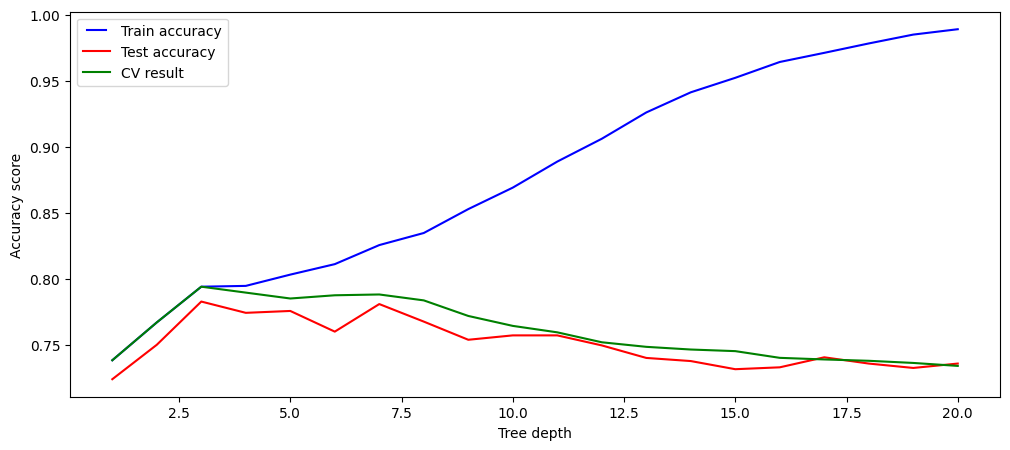

In [ ]:
#The block of code can be omitted {not graded persumably} but may be useful
#Visualize the approximate relationship between accuracy and tree depth
#Experiment with different hyperparameters
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

max_depth = np.arange(1,21,1)

train_results =[]
test_results = []
cv_results =[]

for max_depth_i in max_depth:
  dt = DecisionTreeClassifier(max_depth=max_depth_i,criterion='entropy')
  dt.fit(xtrain,ytrain)

  train_pred = dt.predict(xtrain)
  train_accuracy = accuracy_score(ytrain,train_pred,normalize=True)
  train_results.append(train_accuracy)

  test_pred = dt.predict(xtest)
  test_accuracy = accuracy_score(ytest, test_pred,normalize=True)
  test_results.append(test_accuracy)

  cv_accuracy = cross_val_score(dt,xtrain,ytrain,cv=10)
  cv_results.append(cv_accuracy.mean())

from matplotlib.legend_handler import HandlerLine2D
plt.figure(figsize=(12,5))
line1, = plt.plot(max_depth, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depth, test_results, 'r', label='Test accuracy')
line3, = plt.plot(max_depth, cv_results, 'g', label='CV result')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')
plt.show()

In [ ]:
#Find Hyperparameters by testing
max_depth = np.arange(1,21,1)
min_samples_split = np.arange(0,301,25)
try_grid = [{'max_depth':max_depth,
             'min_samples_split':min_samples_split}]
DTM = GridSearchCV(DecisionTreeClassifier(), param_grid=try_grid, cv=10)
DTM.fit(xtrain,ytrain)
print(f'Best hyperparameters for the models are: {DTM.best_params_}')
print(f'Best model performance: {DTM.best_score_}')

#Optimal max depth is 7, min samples split is 150

Best hyperparameters for the models are: {'max_depth': np.int64(7), 'min_samples_split': np.int64(150)}
Best model performance: 0.7980524085159717


In [ ]:
#Optimal Tree Training & Tree Visualization
from sklearn import tree
fig = plt.figure(figsize=(200,100))

OptimalTree = DecisionTreeClassifier(max_depth = 7, min_samples_split = 150, criterion='entropy')
OptimalTree.fit(xtrain,ytrain)

_ = tree.plot_tree(OptimalTree,feature_names=features,class_names=["Yes","No"],filled=True)

In [ ]:
#Alternative Model Performance Metrics with cross validation
dt_cv_accuracy = cross_val_score(OptimalTree,xtrain,ytrain,scoring='accuracy').mean()
dt_cv_precision = cross_val_score(OptimalTree,xtrain,ytrain,scoring='precision').mean()
dt_cv_recall = cross_val_score(OptimalTree,xtrain,ytrain,scoring='recall').mean()
dt_cv_auc = cross_val_score(OptimalTree,xtrain,ytrain,scoring='roc_auc').mean()

print(f'Using Cross Validation, the best decision tree model accuracy is {dt_cv_accuracy}, precision is {dt_cv_precision}, recall is {dt_cv_recall}, AUC is {dt_cv_auc}')

Using Cross Validation, the best decision tree model accuracy is 0.7915502868226652, precision is 0.6262459629521674, recall is 0.49966820498899045, AUC is 0.8259979148818216


**Task 1, Question 3: Is decision tree or logistic regression better?**

a) Carefully examine various performance metrics and comment about the differences in performance between the two methods.

b) Compare the good features identified by the decision tree and logistic regression

c) try to provide explanations about why they are different

In [ ]:
#Comparing the results
rows = [
    ["Decision Tree", f"{dt_cv_accuracy:.4f}", f"{dt_cv_precision:.4f}", f"{dt_cv_recall:.4f}", f"{dt_cv_auc:.4f}"],
    ["Logistic Regression (L1, best)", f"{l1_cv_accuracy:.4f}", f"{l1_cv_precision:.4f}", f"{l1_cv_recall:.4f}", f"{l1_cv_auc:.4f}"],
]

print(tabulate(rows, headers=["Model", "Accuracy", "Precision", "Recall", "AUC"]))
#Logistic Regression is better across all major metrics

Model                             Accuracy    Precision    Recall     AUC
------------------------------  ----------  -----------  --------  ------
Decision Tree                       0.7916       0.6262    0.4997  0.826
Logistic Regression (L1, best)      0.8046       0.6563    0.5322  0.8473


In [ ]:
#Good features of L1 Logistic Regression
l1_filtered

,tenure,InternetService_Fiber optic,OnlineSecurity_No,TechSupport_No,Contract_Month-to-month,Contract_Two year
0,-0.851633,0.420074,0.171792,0.175463,0.329545,-0.204679


In [ ]:
#Good features of Decision Tree
dt_features_importance = pd.Series(OptimalTree.feature_importances_, index=xtrain.columns).sort_values(ascending=False)
dt_features_importance

,0
Contract_Month-to-month,0.489213
tenure,0.167766
InternetService_Fiber optic,0.115879
MonthlyCharges,0.089799
Contract_Two year,0.031153
TechSupport_No,0.025894
PaymentMethod_Electronic check,0.023043
TechSupport_Yes,0.010221
StreamingMovies_Yes,0.007920
DeviceProtection_Yes,0.005919
